## Objective: Identify Tweets About Real Disasters

Our objective is to train a model to accurately identify tweets that are about real disasters. We will be using Recurrent Neural Networks in order to achieve our goal. Since our objective is to identify tweets about real disasters vs. all others this is a binary classification problem.

In [1]:
## Import Libraries

import numpy as np
import pandas as pd

import tensorflow as tf
import keras

import sklearn

keras.utils.set_random_seed(8122) ## for reproducability

#Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

#Models and preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.models import Sequential
from keras.layers import Embedding, InputLayer, GRU, BatchNormalization, Bidirectional, LSTM, Dense, Dropout, TextVectorization

import keras_tuner

#Optimizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

#Evaluation
from sklearn.model_selection import train_test_split
import keras.backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score


2024-01-25 15:09:27.178723: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('~/Desktop/Deep Learning/nlp-disaster-tweets/train.csv')
test = pd.read_csv('~/Desktop/Deep Learning/nlp-disaster-tweets/test.csv')

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Cleaning the Data



In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


While reviewing the data using the info method we can see that there are 7,613 tweets in our training set with 4 features: "keyword", "location", "text", and "target". 

The target feature shows whether a tweet is about a real disaster (1) or not (0). 

We can see that there are some features with null values: the location feature has 2,533 null values and the keyword feature has 61. It is difficult to impute a location or keyword for our dataset so we are, instead, forced to look at other options.

Given that "keyword" has only 61 null values it is economical to simply remove those rows however if we remove all rows with a null value for "location" we will be removing approximately 33% of our training dataset which is far too much. Instead, we can encode the null value as the string "0" in order to include those rows in our analysis. 

In [4]:
#drop rows with null keywords
df = train.dropna(subset=['keyword'])

df['location'] = df['location'].fillna("")

/var/folders/b2/mncs7bqx383fz9mcvwskngh00000gn/T/ipykernel_73101/1515736361.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['location'] = df['location'].fillna("")


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7552 entries, 31 to 7582
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7552 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  7552 non-null   object
 3   text      7552 non-null   object
 4   target    7552 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 354.0+ KB


Now we can see that there are 7,552 total entries with no null values.

The text of these tweets include social media specific language such as hashtags and URLs in some instances. While hashtags may provide some information for the model to learn from, URLs are unlikely to be helpful and so should be removed.

In [6]:
## Remove URLs from text

df['text'] = df['text'].str.replace('http\S+|www.\S+', '', regex=True, case=False)
test['text'] = test['text'].str.replace('http\S+|www.\S+', '', regex=True, case=False)

/var/folders/b2/mncs7bqx383fz9mcvwskngh00000gn/T/ipykernel_73101/3750252900.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].str.replace('http\S+|www.\S+', '', regex=True, case=False)


## Exploring the Data

In [7]:
#Explore length of texts
df['len'] = df['text'].str.len()

df['len'].describe()

/var/folders/b2/mncs7bqx383fz9mcvwskngh00000gn/T/ipykernel_73101/3298500937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len'] = df['text'].str.len()


count    7552.000000
mean       87.494041
std        32.487667
min         6.000000
25%        63.000000
50%        90.000000
75%       114.000000
max       157.000000
Name: len, dtype: float64

[Text(0.5, 0, 'Length of Tweet (in characters)'), Text(0, 0.5, 'Count')]

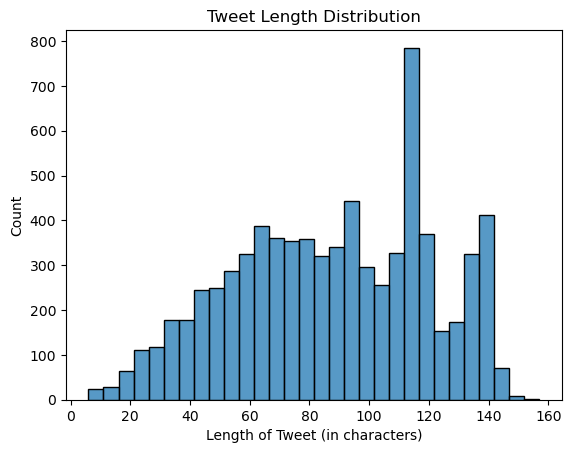

In [8]:
#plot lengths of texts

plot = sns.histplot(data=df, x='len')
plot.set_title('Tweet Length Distribution')
plot.set(xlabel='Length of Tweet (in characters)', ylabel='Count')


It appears that the plurality of tweets are around 115 characters long, after removing URLs.

/var/folders/b2/mncs7bqx383fz9mcvwskngh00000gn/T/ipykernel_73101/1603806953.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_hash'] = df['text'].str.count('#')


<Axes: title={'center': 'Distribution of Hashtags by Tweet'}, xlabel='Hashtags', ylabel='Count'>

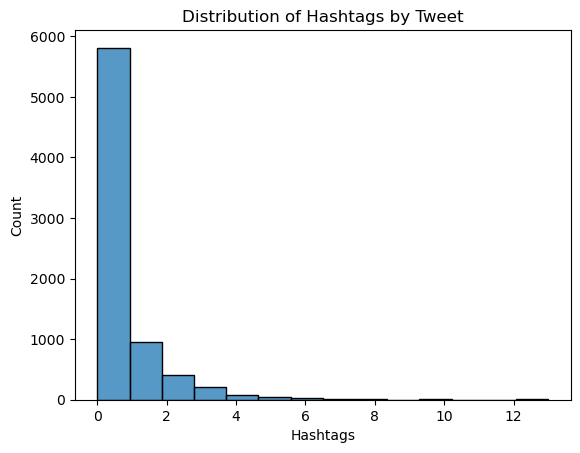

In [9]:
df['num_hash'] = df['text'].str.count('#')

plot = sns.histplot(data=df, x='num_hash')
plot.set_title('Distribution of Hashtags by Tweet')
plot.set(xlabel='Hashtags', ylabel='Count')

plot

We can see that the vast majority of tweets contain between 0-1 hashtags in the training dataset. 

<Axes: title={'center': 'Number of Tweets by True Label'}, xlabel='True Label', ylabel='Count'>

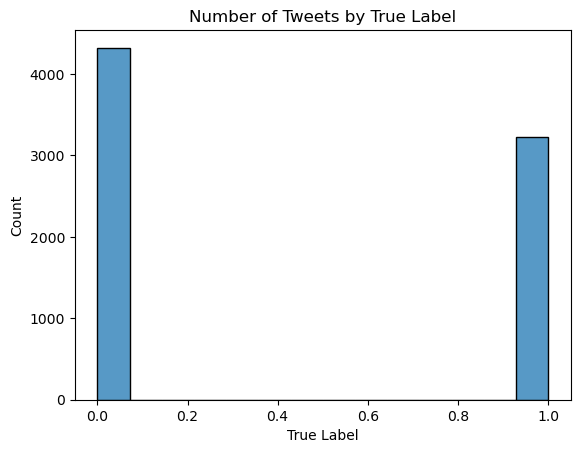

In [10]:
plot = sns.histplot(data=df, x='target')
plot.set_title('Number of Tweets by True Label')
plot.set(xlabel='True Label', ylabel='Count')

plot

In [11]:
real = len(df[df['target'] == 1])
false_disaster = len(df[df['target'] == 0])
real_percent = round((real / (real + false_disaster)) * 100,2)
false_percent = round(100 - real_percent,2)

print(f"We can see that there are less tweets regarding real disasters than false ones in the training data.")
print(f"Real disasters make up {real_percent}% of the training data, while false ones make up {false_percent}%")
print("This shows that our dataset is relatively balanced between the two categories.")

We can see that there are less tweets regarding real disasters than false ones in the training data.
Real disasters make up 42.76% of the training data, while false ones make up 57.24%
This shows that our dataset is relatively balanced between the two categories.


We can see that our dataset is relatively balanced which means that we can rely more on metrics like accuracy that are sensitive to unbalanced datasets in order to determine the efficacy of our models.

## Preparing the Data for Modeling

In order to allow the model to learn from keywords and locations, we can concatenate that information to the text column to create a new string, "content". 

In [12]:
#Combine keywords and location to text

df['content'] = df['keyword'] + '_' + df['text'] + '_' + df['location']

df['content_len'] = df['content'].str.len()

df['content_len'].describe()


/var/folders/b2/mncs7bqx383fz9mcvwskngh00000gn/T/ipykernel_73101/3094229442.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['keyword'] + '_' + df['text'] + '_' + df['location']
/var/folders/b2/mncs7bqx383fz9mcvwskngh00000gn/T/ipykernel_73101/3094229442.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content_len'] = df['content'].str.len()


count    7552.000000
mean      107.410222
std        34.672292
min        16.000000
25%        81.000000
50%       109.000000
75%       135.000000
max       195.000000
Name: content_len, dtype: float64

In [13]:
#split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['content'], df['target'], test_size=0.2)


train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))


In [14]:
BUFFER_SIZE = 8000 #larger than total tweets
BATCH_SIZE = 64

#batch and shuffle training dataset
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [15]:
#confirm the dataset has been created and batched correctly

for example, label in train_ds.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'floods_Nearly 50 thousand people affected by floods in #Paraguay ?  _North America'
 b'accident_8/6/2015@2:09 PM: TRAFFIC ACCIDENT NO INJURY at 2781 WILLIS FOREMAN RD _'
 b'refugees_A Turkish couple spent their wedding day feeding 4000 Syrian refugees  ? A Turkish couple who got marrie \xc2\x89\xc3\x9b_ _']

labels:  [1 1 0]


## Vectorizing the Text Data

In order for our neural network to learn from our text dataset we must vectorize it. Vectorizing allows us to transform our string data to a vector of integers which is digestible to neural networks.

We will be using the TextVectorization layer provided by Keras which automates a lot of the preprocessing tasks with the following parameters:

**standardize** : lower_and_strip_punctuation (default)

The default standardize parameter automatically transforms all text to lowercase and strips punctuation.

**split**: whitespace (default)

The default whitespace parameter will transform the string into a list of tokens by splitting on whitespace.

**max_tokens**: 15,000

The max_tokens size corresponds to the total size of the vocabulary of token ngrams created by the vectorizing layer. Token ngrams that are less common will be replaced with a general "unknown" token to denote that the token is outside of the vocabulary created by the layer.

### A note on Embedding Layers

After vectorizing our text we will feed the created vectors to an embedding layer provided by Keras. The Embedding layer will transform the sparse bag-of-words vectors created by the text vectorization layer to a dense vector. This imbues each token ngram with potentially more information for the model to learn from. The embedding layer will train along with the rest of the model to position similar token vectors together. 

In [16]:
vocab_size = 15000 #max size of vocabulary

encoder = TextVectorization(max_tokens=vocab_size)

#adapt the text vectorization layer to full content of tweets
encoder.adapt(train_ds.map(lambda text, label: text))


In [17]:
#Confirm encoder correctly vectorizes the text

for example, label in train_ds.take(1):
    example = encoder(example)
    print('encoded texts: ', example.numpy()[:3])
    print('')
    print('labels: ', label.numpy()[:3])

encoded texts:  [[    1  2739  3431  1447   719   276     3   301  3988   178     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [ 7876  2287 12314 10004     6    33   132    38  7866   204    31    71
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [ 9682     2   706  2176   132    55     9    18     9 13550  7368     8
    103 14567     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]]

labels:  [1 0 0]


## Evaluating RNN for Classification Task

We will be looking at 3 different types of RNNs for this classification problem: Long Short-Term Memory (LSTM), Bidirectional LSTM, and Gated Recurrent Units (GRUs.) 

The Kaggle competition evaluates models based on the F1 Score. 

Unfortunately, there is currently an error when attempting to evaluate Keras's provided F1 Score during model fit so it is necessary to manually calculate the f1 score ourselves and provide it to the metrics for our models when training. This will give us an idea of possible F1 Scores during training and we will calculate a final F1 score on the validation data afterwards for comparison.

In [18]:
def f1_score(y_true, y_pred): 
    """
    Custom f1_score that is compatible with text classification
    problems in Keras. Credit to Aakash Goel
    https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


callback = EarlyStopping(patience=3, #early stopping if val_loss worsens <patience> number of times.
                        restore_best_weights=True) #restores the weights from the best iteration during training


## Building a Simple LSTM Classifier

In [19]:
simple_lstm = Sequential(name='simple_LSTM')
simple_lstm.add(encoder) #add vectorizer layer to model
simple_lstm.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #Masking zero allows for the model to handle varying sequence length
simple_lstm.add(LSTM(128,
                     dropout=.2,
                     recurrent_dropout=.1,
                     return_sequences=True))
simple_lstm.add(LSTM(128,
                     dropout=.2,
                    recurrent_dropout=.1))
simple_lstm.add(Dense(128, activation='relu'))
simple_lstm.add(Dropout(.2))
simple_lstm.add(Dense(64, activation='relu'))
simple_lstm.add(Dense(1, activation='sigmoid'))

simple_lstm.summary()

Model: "simple_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          960000    
                                                                 
 lstm (LSTM)                 (None, None, 128)         98816     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                       

For the LSTM model we start with the standard preprocessing text vectorization and embedding layers before moving to two LSTM layers of 128 units. Both LSTM layers include a dropout and recurrent_dropout parameter which provides dropout for the final activation and while calculating the recurrent state accordingly. Dropout parameters and layers help to prevent overfitting and allow the model to generalize better. 

After the LSTM layers we move into 2 hidden dense layers, separated by another dropout layer, before proceeding to the final single unit dense layer with a sigmoid activation function. The final layer will calculate a value between 0 and 1 which represents the probability that the ingested tweet is about a real disaster (1) or not (0).

In [20]:
opt = Adam(learning_rate=0.001)

simple_lstm.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[f1_score])


In [21]:
#Train the model
simple_lstm_history = simple_lstm.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                    validation_steps=1,
                    callbacks=[callback],
                    verbose=1)


Epoch 1/30
95/95 [==============================] - 13s 72ms/step - loss: 0.5676 - f1_score: 0.4840 - val_loss: 0.5454 - val_f1_score: 0.5556
Epoch 2/30
95/95 [==============================] - 6s 64ms/step - loss: 0.3157 - f1_score: 0.8431 - val_loss: 0.5779 - val_f1_score: 0.6885
Epoch 3/30
95/95 [==============================] - 6s 64ms/step - loss: 0.1768 - f1_score: 0.9266 - val_loss: 0.6287 - val_f1_score: 0.5294
Epoch 4/30
95/95 [==============================] - 6s 67ms/step - loss: 0.1144 - f1_score: 0.9564 - val_loss: 0.7655 - val_f1_score: 0.7059


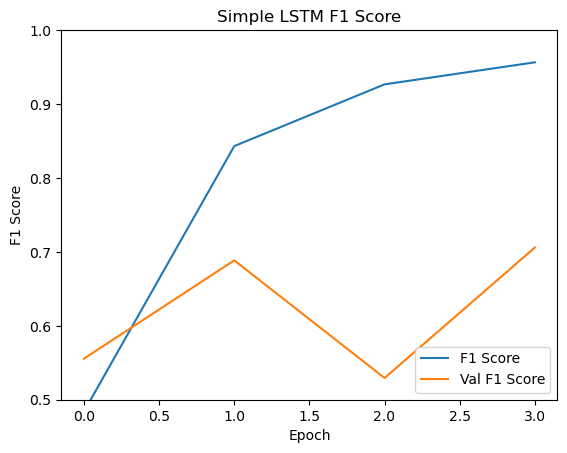

In [22]:
plt.plot(simple_lstm_history.history['f1_score'], label='F1 Score')
plt.plot(simple_lstm_history.history['val_f1_score'], label = 'Val F1 Score')
plt.title('Simple LSTM F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


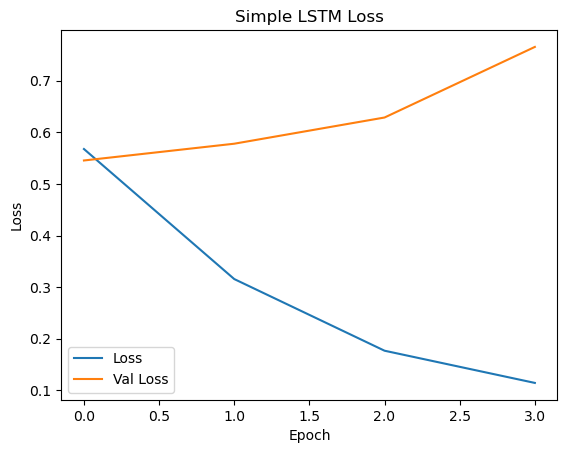

In [23]:
plt.plot(simple_lstm_history.history['loss'], label='Loss')
plt.plot(simple_lstm_history.history['val_loss'], label = 'Val Loss')
plt.title('Simple LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

Based on the plots above we can see some classic overfitting: the training loss continues to decrease while the validation loss begins to increase as the model becomes better at predicting against the training data and worse at making generalizations with data it was not trained on. 

We use early stopping in order to minimize the damage overfitting does as much as possible.

## Using Bidirectional LSTM

In [24]:
bi_lstm = Sequential(name='bi_LSTM')
bi_lstm.add(encoder) #add vectorizer layer to model
bi_lstm.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #Masking zero allows for the model to handle varying sequence length
bi_lstm.add(Bidirectional(LSTM(128,
                               dropout=.2,
                               recurrent_dropout=.1,
                               return_sequences=True)))
bi_lstm.add(Bidirectional(LSTM(64,
                              dropout=.2,
                              recurrent_dropout=.1)))
bi_lstm.add(Dense(128, activation='relu'))
bi_lstm.add(Dropout(.2))
bi_lstm.add(Dense(64, activation='relu'))
bi_lstm.add(Dense(1, activation='sigmoid'))

bi_lstm.summary()

Model: "bi_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          960000    
                                                                 
 bidirectional (Bidirection  (None, None, 256)         197632    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                           

The second model we will look at is a Bidirectional LSTM model. The Bidirectional wrapper on the LSTM layer allows the LSTM to take into account both t-1 and t+1 when learning the data. Including the tokens before and after each token may provide the model with more information to learn from and produce more accurate results. Similarly to the first model, we will use dropout layers and recurrent_dropouts in order to help it generalize.

While the Bidirectional LSTM layers allow for more information to be processed, it also effectively doubles the number of calculations to make which can result in slowdown during the training process.

In [25]:
opt = Adam(learning_rate=0.001)

bi_lstm.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[f1_score])

In [26]:
bi_lstm_history = bi_lstm.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                    validation_steps=1,
                    callbacks=[callback],
                    verbose=1)


Epoch 1/30
95/95 [==============================] - 23s 126ms/step - loss: 0.5626 - f1_score: 0.4785 - val_loss: 0.5919 - val_f1_score: 0.5957
Epoch 2/30
95/95 [==============================] - 11s 112ms/step - loss: 0.2967 - f1_score: 0.8536 - val_loss: 0.5904 - val_f1_score: 0.6087
Epoch 3/30
95/95 [==============================] - 11s 115ms/step - loss: 0.1528 - f1_score: 0.9368 - val_loss: 0.5721 - val_f1_score: 0.6522
Epoch 4/30
95/95 [==============================] - 11s 112ms/step - loss: 0.0921 - f1_score: 0.9616 - val_loss: 0.7753 - val_f1_score: 0.6250
Epoch 5/30
95/95 [==============================] - 11s 111ms/step - loss: 0.0632 - f1_score: 0.9746 - val_loss: 0.8233 - val_f1_score: 0.7857
Epoch 6/30
95/95 [==============================] - 11s 114ms/step - loss: 0.0549 - f1_score: 0.9804 - val_loss: 1.0148 - val_f1_score: 0.5714


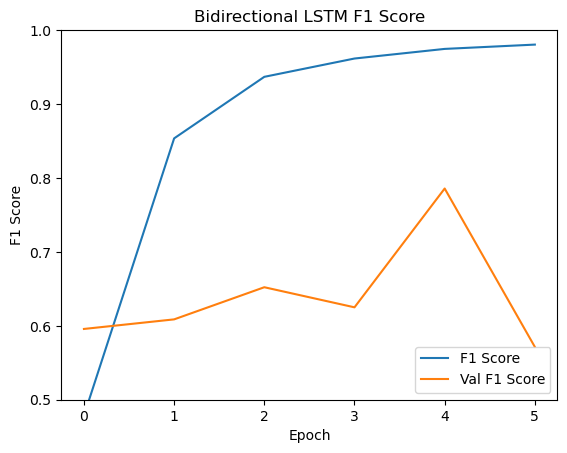

In [27]:
plt.plot(bi_lstm_history.history['f1_score'], label='F1 Score')
plt.plot(bi_lstm_history.history['val_f1_score'], label = 'Val F1 Score')
plt.title("Bidirectional LSTM F1 Score")
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


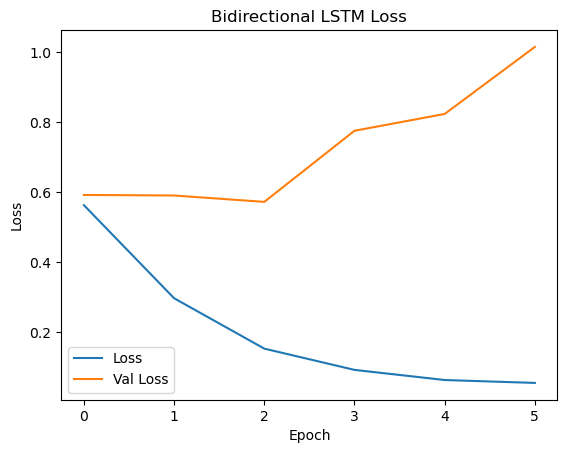

In [28]:
plt.plot(bi_lstm_history.history['loss'], label='Loss')
plt.plot(bi_lstm_history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.title("Bidirectional LSTM Loss")
plt.ylabel('Loss')
plt.legend(loc='lower left')

We can see that the bidirectional model is also affected by overfitting but maintains similar results to the simple LSTM model.

## Using Gated Recurrent Units (GRUs)

In [29]:
gru = Sequential(name='GRU')
gru.add(encoder) #add vectorizer layer to model
gru.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #Masking zero allows for the model to handle varying sequence length
gru.add(GRU(128, 
            dropout=.2,
            recurrent_dropout=.1,
            return_sequences=True))
gru.add(GRU(64,
           dropout=.1,
           recurrent_dropout=.1))
gru.add(Dense(128, activation='relu'))
gru.add(Dropout(.2))
gru.add(Dense(64, activation='relu'))
gru.add(Dense(1, activation='sigmoid'))

gru.summary()

Model: "GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          960000    
                                                                 
 gru (GRU)                   (None, None, 128)         74496     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                               

Gated Recurrent Units (GRUs) allow for the processing of time series data like LSTM with less overhead. We can employ a similar architecture with two GRU units followed by Dense layers with dropouts to help with generalization. 

In [30]:
opt = Adam(learning_rate=0.001)

gru.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=[f1_score])

In [31]:
gru_history = gru.fit(train_ds, epochs=30,
                    validation_data=val_ds,
                    validation_steps=1,
                    callbacks=[callback],
                    verbose=1)


Epoch 1/30
95/95 [==============================] - 9s 50ms/step - loss: 0.5740 - f1_score: 0.4361 - val_loss: 0.5404 - val_f1_score: 0.6667
Epoch 2/30
95/95 [==============================] - 4s 44ms/step - loss: 0.3260 - f1_score: 0.8342 - val_loss: 0.5442 - val_f1_score: 0.6531
Epoch 3/30
95/95 [==============================] - 4s 46ms/step - loss: 0.1776 - f1_score: 0.9237 - val_loss: 0.5619 - val_f1_score: 0.6190
Epoch 4/30
95/95 [==============================] - 4s 45ms/step - loss: 0.0993 - f1_score: 0.9608 - val_loss: 0.6287 - val_f1_score: 0.6923


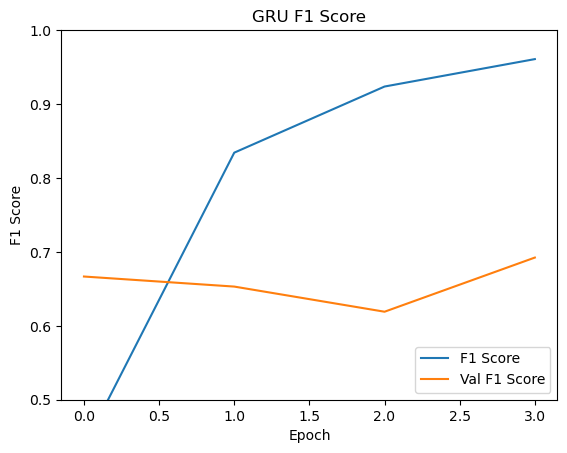

In [32]:
plt.plot(gru_history.history['f1_score'], label='F1 Score')
plt.plot(gru_history.history['val_f1_score'], label = 'Val F1 Score')
plt.title('GRU F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

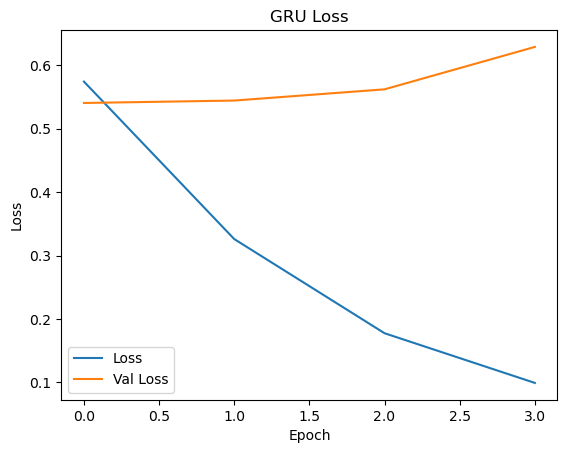

In [33]:
plt.plot(gru_history.history['loss'], label='Loss')
plt.plot(gru_history.history['val_loss'], label = 'Val Loss')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')

As with the other Recurrent Neural Networks, the GRU model also experiences overfitting that must be fought against with early stopping. 

We can see that the model appears to maintain similar performance as the other two networks during training however the time spent to train is significantly reduced which is a great benefit to this architecture.

## Comparing Models

In [34]:
#Predict
y_prediction = simple_lstm.predict(X_val)
y_prediction = np.where(y_prediction > .5, 1, 0)

#Create confusion matrix
lstm_conf = confusion_matrix(y_val, y_prediction)


precision = precision_score(y_val, y_prediction)
recall = recall_score(y_val, y_prediction)
accuracy = accuracy_score(y_val, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val, y_prediction)

metrics = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1_Score"])

metrics.loc['Simple_LSTM'] = [accuracy, precision, recall, f1_score]

metrics

48/48 [==============================] - 1s 10ms/step


,Accuracy,Precision,Recall,F1_Score
Simple_LSTM,0.778954,0.875895,0.565485,0.687266


[Text(0.5, 1.0, 'Simple LSTM Confusion Matrix'),
 Text(0.5, 23.52222222222222, 'True Label'),
 Text(50.722222222222214, 0.5, 'Predicted Label')]

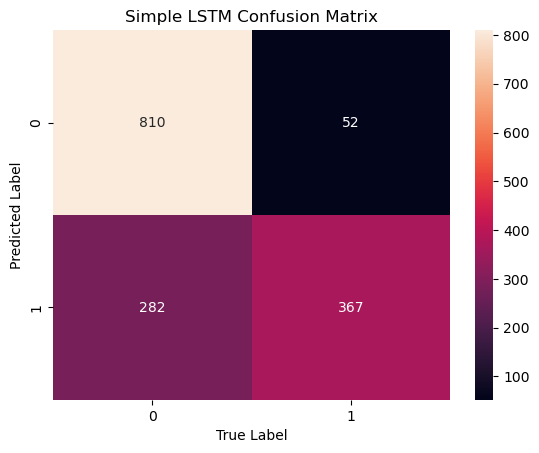

In [35]:
sns.heatmap(lstm_conf, annot=True, fmt='1g').set(
    title='Simple LSTM Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label'
)


In [36]:
#Predict
y_prediction = bi_lstm.predict(X_val)
y_prediction = np.where(y_prediction > .5, 1, 0)


#Create confusion matrix
bi_conf = confusion_matrix(y_val, y_prediction)

precision = precision_score(y_val, y_prediction)
recall = recall_score(y_val, y_prediction)
accuracy = accuracy_score(y_val, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val, y_prediction)

metrics.loc['Bidirectional_LSTM'] = [accuracy, precision, recall, f1_score]

metrics

48/48 [==============================] - 2s 13ms/step


,Accuracy,Precision,Recall,F1_Score
Simple_LSTM,0.778954,0.875895,0.565485,0.687266
Bidirectional_LSTM,0.749835,0.717496,0.688752,0.702830


[Text(0.5, 1.0, 'Bidirectional LSTM Confusion Matrix'),
 Text(0.5, 23.52222222222222, 'True Label'),
 Text(50.722222222222214, 0.5, 'Predicted Label')]

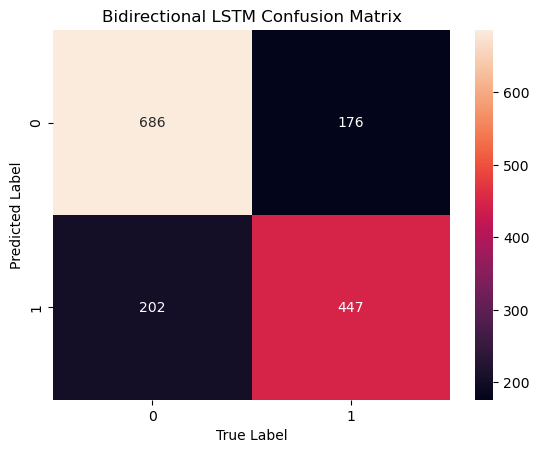

In [37]:
sns.heatmap(bi_conf, annot=True, fmt='1g').set(
    title='Bidirectional LSTM Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label'
)


In [38]:
#Predict
y_prediction = gru.predict(X_val)
y_prediction = np.where(y_prediction > .5, 1, 0)


#Create confusion matrix
gru_conf = confusion_matrix(y_val, y_prediction)

precision = precision_score(y_val, y_prediction)
recall = recall_score(y_val, y_prediction)
accuracy = accuracy_score(y_val, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val, y_prediction)

metrics.loc['GRU'] = [accuracy, precision, recall, f1_score]

metrics


48/48 [==============================] - 1s 6ms/step


,Accuracy,Precision,Recall,F1_Score
Simple_LSTM,0.778954,0.875895,0.565485,0.687266
Bidirectional_LSTM,0.749835,0.717496,0.688752,0.702830
GRU,0.767042,0.879795,0.530046,0.661538


[Text(0.5, 1.0, 'GRU Confusion Matrix'),
 Text(0.5, 23.52222222222222, 'True Label'),
 Text(50.722222222222214, 0.5, 'Predicted Label')]

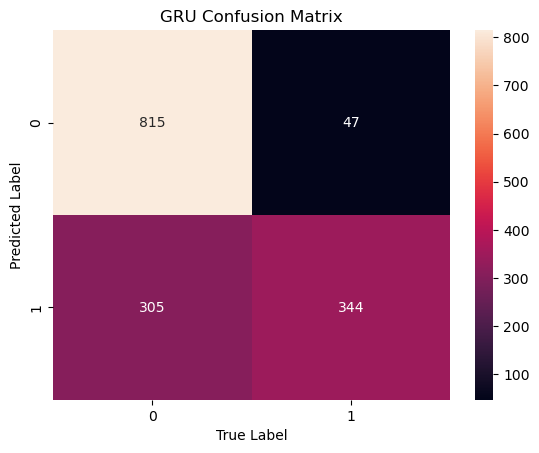

In [39]:
sns.heatmap(gru_conf, annot=True, fmt='1g').set(
    title='GRU Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label'
)


## Improving GRU Model via Hyperparameter Tuning

We can see that the models perform similarly with the simple LSTM model performing the best overall. Trial and error resulted in the above configurations for the models but we can automate finding the optimal hyperparameters using hyperparameter tuning.

We will use keras's keras_tuner to perform a hyperparameter search to find the optimal configuration for our GRU model. We will use hyperparameter tuning to determine the optimal number of GRU layers and associated dropouts, Dense layers, dropout layers, and learning rate.

In [53]:
def build_model(hp):
    """
    Function to tune a GRU model using the keras_tuner library
    and conditional hyperparameters.
    """
    model = Sequential(name='GRU_tuned')
    model.add(encoder) #add vectorizer layer to model
    model.add(Embedding(input_dim=vocab_size, 
                     output_dim=64, 
                     mask_zero=True)) #
    
    if hp.Boolean("second_GRU_layer"):
                
        model.add(GRU(units=hp.Int(f"first_GRU_units", min_value=64, max_value=512, step=32), 
                dropout=hp.Float("first_GRU_dropout",min_value=.05, max_value=.3),
                recurrent_dropout=hp.Float("first_GRU_rec_dropout", min_value=.05, max_value=.3),
                return_sequences=True))

        with hp.conditional_scope("second_GRU_layer", True):

            model.add(GRU(units=hp.Int(f"second_GRU_units", min_value=32, max_value=512, step=32),
                   dropout=hp.Float("second_GRU_dropout",min_value=.05, max_value=.3),
                   recurrent_dropout=hp.Float("second_GRU_rec_dropout",min_value=.05, max_value=.3)
                ))
            
    else:
        
        model.add(GRU(units=hp.Int(f"first_GRU_units", min_value=64, max_value=512, step=32), 
                dropout=hp.Float("first_GRU_dropout",min_value=.05, max_value=.3),
                recurrent_dropout=hp.Float("first_GRU_rec_dropout", min_value=.05, max_value=.3)
                ))
    
    if hp.Boolean("first_dropout"):
        with hp.conditional_scope("first_dropout", True):
            model.add(Dropout(rate=hp.Float("first_dropout_rate", min_value=.05, max_value=.3)))
        
    #Add 1-2 Dense Layers
    for i in range(hp.Int("num_layers", 1, 2)):
        
        if hp.Boolean("inter_drop"):
            with hp.conditional_scope("inter_drop", True):
                if i > 1: #only add dropout between dense layers
                    model.add(Dropout(rate=hp.Float("inter_dropout_rate", min_value=.05, max_value=.3)))
                
        model.add(
            Dense(
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        
    
    if hp.Boolean("final_dropout"):
        with hp.conditional_scope("final_dropout", True):
            model.add(Dropout(rate=hp.Float("final_dropout_rate", min_value=.05, max_value=.3)))
        
    model.add(Dense(1, activation='sigmoid'))
    
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    
    return model


In [54]:
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    max_trials = 20,
    overwrite=True,
    objective="val_accuracy",
    directory="./",
    project_name="gru_tuning",
)

tuner.search_space_summary()

Search space summary
Default search space size: 11
second_GRU_layer (Boolean)
{'default': False, 'conditions': []}
first_GRU_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
first_GRU_dropout (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.3, 'step': None, 'sampling': 'linear'}
first_GRU_rec_dropout (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.3, 'step': None, 'sampling': 'linear'}
first_dropout (Boolean)
{'default': False, 'conditions': []}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
inter_drop (Boolean)
{'default': False, 'conditions': []}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
final_dropout (Boolean)


In [55]:
### Perform the search over the hyperparameter space

tuner.search(train_ds, 
             epochs=10,
             validation_data=val_ds,
             callbacks=[EarlyStopping(monitor='val_accuracy', patience=1)]
            )

Trial 20 Complete [00h 00m 29s]
val_accuracy: 0.7683653235435486

Best val_accuracy So Far: 0.7796161770820618
Total elapsed time: 00h 20m 24s


In [60]:
## Retrieve summary of all trials 

tuner.results_summary()

Results summary
Results in ./gru_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 02 summary
Hyperparameters:
second_GRU_layer: True
first_GRU_units: 288
first_GRU_dropout: 0.25226363039318495
first_GRU_rec_dropout: 0.19583929732795874
first_dropout: False
num_layers: 2
inter_drop: False
units_0: 512
activation: relu
final_dropout: False
lr: 0.00044124415805296913
units_1: 64
second_GRU_units: 448
second_GRU_dropout: 0.2803719916086604
second_GRU_rec_dropout: 0.2842932500253286
Score: 0.7796161770820618

Trial 18 summary
Hyperparameters:
second_GRU_layer: False
first_GRU_units: 96
first_GRU_dropout: 0.239224120584348
first_GRU_rec_dropout: 0.08742477392644486
first_dropout: True
num_layers: 2
inter_drop: False
units_0: 320
activation: tanh
final_dropout: False
lr: 0.0002606523259860789
first_dropout_rate: 0.23288599269090549
units_1: 64
Score: 0.7796161770820618

Trial 17 summary
Hyperparameters:
second_GRU_layer: False
first_GRU_units: 416
first_GRU

In [61]:
## Retrieve the best model from keras tuner

models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "GRU_tuned"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          960000    
                                                                 
 gru (GRU)                   (None, None, 288)         305856    
                                                                 
 gru_1 (GRU)                 (None, 448)               991872    
                                                                 
 dense (Dense)               (None, 512)               229888    
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                         

In [62]:
#Predict
y_prediction = best_model.predict(X_val)
y_prediction = np.where(y_prediction > .5, 1, 0)


#Create confusion matrix
best_gru_conf = confusion_matrix(y_val, y_prediction)

precision = precision_score(y_val, y_prediction)
recall = recall_score(y_val, y_prediction)
accuracy = accuracy_score(y_val, y_prediction)
f1_score = sklearn.metrics.f1_score(y_val, y_prediction)

metrics.loc['tuned_GRU'] = [accuracy, precision, recall, f1_score]

metrics


48/48 [==============================] - 3s 52ms/step


,Accuracy,Precision,Recall,F1_Score
Simple_LSTM,0.778954,0.875895,0.565485,0.687266
Bidirectional_LSTM,0.749835,0.717496,0.688752,0.702830
GRU,0.767042,0.879795,0.530046,0.661538
tuned_GRU,0.779616,0.786232,0.668721,0.722731


[Text(0.5, 1.0, 'Tuned GRU Confusion Matrix'),
 Text(0.5, 23.52222222222222, 'True Label'),
 Text(50.722222222222214, 0.5, 'Predicted Label')]

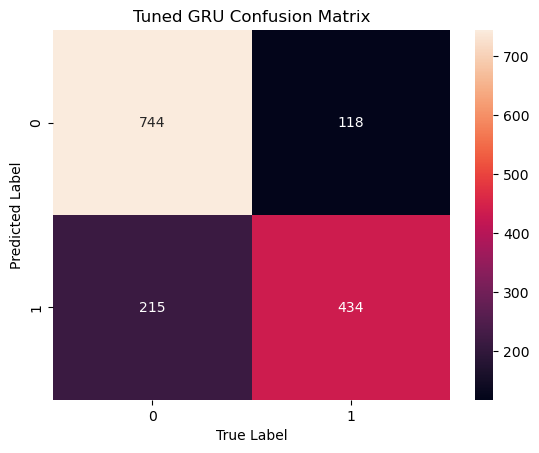

In [63]:
sns.heatmap(best_gru_conf, annot=True, fmt='1g').set(
    title='Tuned GRU Confusion Matrix',
    xlabel = 'True Label',
    ylabel = 'Predicted Label'
)

We can see from the above confusion matrix and metrics dataframe that hyperparameter tuning significantly increases the F1 score for our GRU network. 

## Preparing Test Data for Submission

In [64]:
test['keyword'] = test['keyword'].fillna("")
test['location'] = test['location'].fillna("")

test['content'] = test['keyword'] + '_' + test['text'] + '_' + test['location']

In [65]:
#Predict using Model

#gru
predictions = best_model.predict(test['content'])



102/102 [==============================] - 5s 50ms/step


In [66]:
response = np.where(predictions > .5, 1, 0)

test['target'] = response

In [67]:
answer = test.drop(columns=['keyword', 'location', 'text', 'content'])

answer.head()

answer.to_csv('./submission_tuned_GRU.csv', index=False)